In [2]:
from ple.games.flappybird import FlappyBird
from ple import PLE
import numpy as np
import random
from IPython.display import clear_output
from datetime import datetime
import os
import glob
import shutil
import time
import matplotlib.pyplot as plt

couldn't import doomish
Couldn't import doom


In [2]:
help(FlappyBird)

Help on class FlappyBird in module ple.games.flappybird:

class FlappyBird(ple.games.base.pygamewrapper.PyGameWrapper)
 |  Used physics values from sourabhv's `clone`_.
 |  
 |  .. _clone: https://github.com/sourabhv/FlapPyBird
 |  
 |  
 |  Parameters
 |  ----------
 |  width : int (default: 288)
 |      Screen width. Consistent gameplay is not promised for different widths or heights, therefore the width and height should not be altered.
 |  
 |  height : inti (default: 512)
 |      Screen height.
 |  
 |  pipe_gap : int (default: 100)
 |      The gap in pixels left between the top and bottom pipes.
 |  
 |  Method resolution order:
 |      FlappyBird
 |      ple.games.base.pygamewrapper.PyGameWrapper
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, width=288, height=512, pipe_gap=100)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  game_over(self)
 |      Gets the status of the game, returns True if game has hit a termina

In [6]:
start_time = time.time() #Utilisé pour regarder le temps écoulé lors de l'apprentissage

############################## Définition des paramètres, modifiables #############################
epochs = 10000 #Nombre de parties à jouer
gamma = 0.8 # discount factor 0.8 
alpha = 0.6 # learning rate 0.6
prob = 0.9 #proba de jouer None lors d'un mouvement aléatoire
epsilon = 0 # Initialisation d'epsilon (exploration/exploitation) #0 pour ne pas activer l'exploration aléatoire
print_delay = 250 #Tous les combien de jeux on affiche un résumé et on enregistre le Q
###################################################################################################


############## Initialisation de Q (Décommenter une ligne, commenter l'autre) :####################
#Q = {} # pour reprendre un apprentissage de 0

Q = np.load('Q.npy').item() # pour reprendre l'apprentissage à partir d'un Q existant
###################################################################################################

# Définition des fonctions utilisées et initialisation des variables

#Les récompenses de sortie de p.act(action):
reward_dict = { "positive": 1, "negative": 0.0, "tick": 0, "loss": -1000.0, "win": 0.0}

#Fonction qui prend le jeu en entrée, et retourne une chaîne de caractère caractérisant l'état, de la forme hXXvYYsZZ
#où XX représente l'écart horizontal entre l'oiseau et le prochain tuyau
#YY est l'écart vertical entre l'oiseau et le haut du prochain tuyau
#Les valeurs issues de l'état ont été divisées pour réduire le nombre d'états et améliorer l'apprentissage
def getstate(jeu):
    
    #Acquisition des états sous forme de liste:
    a = list(jeu.getGameState().values())
    
    #Ecart vertical entre l'oiseau et le haut du prochain tuyau, divisé par 10
    #Le +512 a été ajouté pour ne pas avoir de valeurs négatives,
    #ce qui n'as plus d'importance maintenant avec les chaines de
    #caractères utilisées pour stocker les états
    v_pos = np.int(np.round((a[0]-a[3]+512)/10))
    
    #différence de hauteur entre le prochain tuyau avec le tuyau d'après, divisé par 20 pour ne pas avoir trop d'état
    vpos_next = np.int(np.round((a[3]-a[6]+512)/20))

    
    #Distance de l'oiseau au prochain tuyau (+20 idem précédemment) divisé par 10 également
    h_pos = np.int(np.round((a[2]+20)/10))

    
    #Vitesse verticale de l'oiseau, divisée par 2
    speed = np.int(np.round(a[1]/2))
        
    #Création de la chaîne de caractères utilisée pour stocker les états dans le Q:
    S = 'h'+np.str(h_pos)+'v'+np.str(v_pos)+'vn'+np.str(vpos_next)+'s'+np.str(speed)
    
    return S

# Variables utilisées pour voir l'évolution
scores = []
average = []
bests = []
games = []
    
#Initilisation du jeu "jeu" et du joueur "p"
jeu = FlappyBird()

#frame_skip = The number of times we skip getting observations while repeat an action
#num_steps = The number of times we repeat an action.
#force_fps = True pour ne pas jouer en temps réel (plus vite)
#display_screen = True pour afficher le déroulement de la partie en direct
#reward_values = This contains the rewards we wish to set give our agent

p = PLE(jeu, fps=30, frame_skip=1, num_steps=1, force_fps=True, display_screen=True, reward_values = reward_dict)

#Début des parties, on en joue un nombre : epochs
for i in range(epochs):
    
    #Réinitialisation du jeu
    p.reset_game()
    
    #Acquisition de l'état du jeu (s)
    S = getstate(jeu)
    
    #Début de la boucle, tant que la partie n'est pas finie :
    while(not jeu.game_over()):
        
        #Ajout de l'état dans Q si pas encore dedans
        if S not in Q:
            Q[S] = {None : 0, 119 : 0}
            
        #Choix de l'action à effectuer
        if (np.random.random() < epsilon): # On choisit une action au hasard
            if np.random.random() < prob: # proba prob de jouer l'action None
                action = None
            else:
                action = 119
        else: # On choisit la meilleure action, qui maximise Q(s,a)
            if Q[S][119] > Q[S][None]:
                action = 119
            else:
                action = None

        #On fait l'action "action" (a)
        r = p.act(action)
        
        #On observe la récompense liée à cette action
        if r == 0: #Dans ce cas l'oiseau est encore en vie, on donne une récompense de 1
            reward = 1
        elif r == 1: #L'oiseau a franchi un tuyau, on donne une récompense de  100
            reward = 100
        else: #L'oiseau a touché un tuyau, le sol ou le plafond, on fait reward = r = -1000 (cf reward_dict)
            reward = r
        
        # On observe le nouvel état new_S (s')
        new_S = getstate(jeu)
        
        # Si le nouvel état n'est pas dans Q, on l'ajoute
        if new_S not in Q:
            Q[new_S] = {None : 0, 119 : 0}

        # Recherche du max sur a' de Q(s',a')
        maxQ = np.maximum(Q[new_S][None],Q[new_S][119])
        
        #Actualisation de Q(s,a)
        Q[S][action] = Q[S][action] + alpha*(reward + gamma*maxQ - Q[S][action])      

        #On actualise l'état courant
        S = new_S
        
    #Après la fin de la partie, on ajoute le score final à la liste des scores
    scores.append(jeu.getScore()-reward_dict["loss"])
    
    # Mise à jour de la stratégie exploitation / exploration s'il y a lieu
    if epsilon > 0.2:
        epsilon -= (1.0/epochs)
        
    #Sauvegarde du Q courant, et affichage de quelques donnée pour suivre l'apprentissage
    if ((i+1)%print_delay) == 0:
        print("")
        print("Game #: %s" % (i+1,))
        print("Meilleur score sur les ",print_delay," derniers essais =", np.max(scores))
        print("Score moyen sur les ",print_delay," derniers essais =", np.mean(scores))
        elapsed_time = time.time() - start_time
        printime = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
        print("Temps écoulé : ", printime)
        print('Taille du dictionnaire des états = ', len(Q))
        average.append(np.mean(scores))
        bests.append(np.max(scores))
        games.append(i+1)
        dire = './Q_learning_saves/Q_moyenne_'+np.str(np.mean(scores))
        np.save(dire, Q)
        np.save('Q',Q)
        print('Save done avec moyenne: ' + np.str(np.mean(scores)))
        scores = []



Game #: 250
Meilleur score sur les  250  derniers essais = 3.0
Score moyen sur les  250  derniers essais = 0.256
Temps écoulé :  00:00:10
Taille du dictionnaire des états =  79074
Save done avec moyenne: 0.256

Game #: 500
Meilleur score sur les  250  derniers essais = 2.0
Score moyen sur les  250  derniers essais = 0.224
Temps écoulé :  00:00:21
Taille du dictionnaire des états =  79927
Save done avec moyenne: 0.224

Game #: 750
Meilleur score sur les  250  derniers essais = 3.0
Score moyen sur les  250  derniers essais = 0.272
Temps écoulé :  00:00:32
Taille du dictionnaire des états =  80605
Save done avec moyenne: 0.272

Game #: 1000
Meilleur score sur les  250  derniers essais = 2.0
Score moyen sur les  250  derniers essais = 0.232
Temps écoulé :  00:00:44
Taille du dictionnaire des états =  81042
Save done avec moyenne: 0.232

Game #: 1250
Meilleur score sur les  250  derniers essais = 4.0
Score moyen sur les  250  derniers essais = 0.28
Temps écoulé :  00:00:56
Taille du dictio

KeyboardInterrupt: 

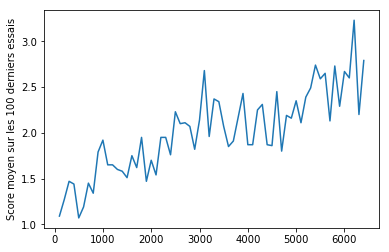

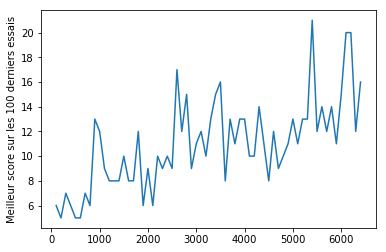

In [10]:
# Affichage des courbes des meilleurs scores et scores moyen lors des dernieres parties enregistrées

plt.plot(games,average)
plt.ylabel('Score moyen sur les ', print_delay,' derniers essais')
plt.show()
plt.plot(games,bests)
plt.ylabel('Meilleur score sur les ', print_delay,' derniers essais')
plt.show()


# Test du modèle
## Utilisation du même script que "run.py" utilisé pour la notation

In [1]:
import numpy as np
from ple.games.flappybird import FlappyBird
from ple import PLE
actions = [None, 119]
Q = np.load('Q_good.npy').item()


def getstate(state):
    
    a = list(state.values())
    v_pos = np.int(np.round((a[0]-a[3]+512)/10)) # Différence de position verticale entre l'oiseau et le bas du prochain tuyau
                          #+512 (hauteur totale en pixels) pour ne jamais être négatif
    h_pos = np.int(np.round((a[2]+20)/10)) #Distance de l'oiseau au prochain tuyau
    
    speed = np.int(np.round(a[1]/2))
    S = 'h'+np.str(h_pos)+'v'+np.str(v_pos)+'s'+np.str(speed)
    return S

def FlappyPolicy(state, screen):
    
    S = getstate(state)
    if S not in Q:
        action = None
    elif Q[S][119]>Q[S][None]:
        action = 119
    else:
        action = None
        
    return action


game = FlappyBird()
p = PLE(game, fps=30, frame_skip=1, num_steps=1, force_fps=True, display_screen=False)

p.init()
reward = 0.0

nb_games = 100
cumulated = np.zeros((nb_games))

for i in range(nb_games):
    p.reset_game()
    
    while(not p.game_over()):
        state = game.getGameState()
        screen = p.getScreenRGB()
        action=FlappyPolicy(state, screen) ### Your job is to define this function.
        
        reward = p.act(action)
        cumulated[i] = cumulated[i] + reward
    print('Game #', i, ' score :',cumulated[i]+5)

average_score = np.mean(cumulated+5)
max_score = np.max(cumulated+5)

print("Score moyen sur les 100 parties :", average_score)
print("Score max sur les 100 parties :", max_score)

if average_score > 15:
    print("YOU WOOOOOOOOOOOOOOOOOOON !!!!!")
else:
    print("Loser.")
        


couldn't import doomish
Couldn't import doom
Game # 0  score : 1.0
Game # 1  score : 4.0
Game # 2  score : 114.0
Game # 3  score : 24.0
Game # 4  score : 14.0
Game # 5  score : 26.0
Game # 6  score : 31.0
Game # 7  score : 24.0
Game # 8  score : 1.0
Game # 9  score : 0.0
Game # 10  score : 162.0
Game # 11  score : 40.0
Game # 12  score : 1.0
Game # 13  score : 26.0
Game # 14  score : 0.0
Game # 15  score : 71.0
Game # 16  score : 3.0
Game # 17  score : 1.0
Game # 18  score : 6.0
Game # 19  score : 89.0
Game # 20  score : 11.0
Game # 21  score : 2.0
Game # 22  score : 18.0
Game # 23  score : 28.0
Game # 24  score : 52.0
Game # 25  score : 15.0
Game # 26  score : 37.0
Game # 27  score : 82.0
Game # 28  score : 108.0
Game # 29  score : 21.0
Game # 30  score : 122.0
Game # 31  score : 0.0
Game # 32  score : 129.0
Game # 33  score : 62.0
Game # 34  score : 21.0
Game # 35  score : 10.0
Game # 36  score : 11.0
Game # 37  score : 14.0
Game # 38  score : 3.0
Game # 39  score : 68.0
Game # 40  s